In [31]:
import time
import numpy as np
import random
import pandas as pd
#import matplotlib.pyplot as plt
import matplotlib
#matplotlib.use('TKAgg')  # Use the TkAgg backend for popup windows
import matplotlib.pyplot as plt
plt.ion()
# plot in floating window

%matplotlib inline

In [32]:
def generate_population(size, cities):
    num_cities = len(cities) + 1
    population = []

    for _ in range(size):
        genes = list(range(2, num_cities))
        random.shuffle(genes)
        #print(genes)
        individual = [1] + genes + [1]
        population.append(individual)
        
    return np.array(population)

In [ ]:
def mutation(route, mutation_rate=0.1):
    """ Inversion Mutation """
    #num_mutations = num_mutations
    mutated_route = route.copy()
    
    if random.random() < mutation_rate:
        i, j = sorted(random.sample(range(1, len(route) - 1), 2))

        mutated_route[i:j + 1] = mutated_route[i:j + 1][::-1]  

    return mutated_route

In [34]:
def troubleshoot(child):

    """Check for duplicates and missing cities in the child."""
    spots = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0,
                11:0, 12:0, 13:0, 14:0, 15:0, 16:0, 17:0, 18:0, 19:0,
                20:0, 21:0, 22:0, 23:0, 24:0, 25:0, 26:0, 27:0,
                28:0, 29:0, 30:0, 31:0, 32:0, 33:0, 34:0, 35:0,
                36:0, 37:0, 38:0, 39:0, 40:0, 41:0,
                42:0, 43:0, 44:0, 45:0, 46:0, 47:0, 48:0, 49:0,
                50:0, 51:0, 52:0}
    
    for i in child:
        spots[i] += 1
        if spots[i] > 1:
            if i == 1 and spots[i] <= 2:
                continue
            print(f"Duplicate city {i} found in child: {child}")
            raise ValueError("Duplicate city found in child during crossover.")
        
    for i in spots:
        if spots[i] == 0:
            print(f"Missing city {i} in child: {child}")
            raise ValueError("Missing city in child during crossover.")

In [ ]:
def crossover(parent1, parent2):
    """ Two-Point Crossover """

    # Exclude the first city from crossover
    size = len(parent1)-1 # 53 -> 52 
    start = 1 # [1, x <- ... , y, 1]

    start_cut = np.random.randint(start, size-2) # max is 50
    end_cut = np.random.randint(start_cut+1, size-1) # max is 51

    child = np.full(len(parent1), -1)
    child[0] = 1 # First city is always 1
    child[-1] = 1 # Last city is always 1
    child[start_cut:end_cut] = parent1[start_cut:end_cut]

    fill_pos = [i for i in range(len(parent1)) if child[i] == -1]

    fill_values = [item for item in parent2 if item not in child[:] and item != 1]

    for pos, value in zip(fill_pos, fill_values):
        child[pos] = value

    #troubleshoot(child)

    return child

In [36]:
def calculate_fitness(individual, citys):
    total_distance = 0
    size = len(individual)

    for i in range(size - 1):
        city1 = citys.iloc[individual[i]-1] #-1
        city2 = citys.iloc[individual[(i + 1)]-1] #-1
        distance = np.sqrt((city1['x'] - city2['x']) ** 2 + (city1['y'] - city2['y']) ** 2)
        total_distance += distance
    return total_distance  


In [37]:
def calculate_fitness_population(population, citys):
    fitness_scores = []
    #size = len(population[0])
    for individual in population:
        """total_distance = 0
        for i in range(size - 1):
            city1 = citys.iloc[individual[i]-1] #-1
            city2 = citys.iloc[individual[(i + 1)]-1] #-1
            distance = np.sqrt((city1['x'] - city2['x']) ** 2 + (city1['y'] - city2['y']) ** 2)
            total_distance += distance
            """
        fitness = calculate_fitness(individual, citys)
        fitness_scores.append(fitness)
    return np.array(fitness_scores)

In [38]:
def roulette(population, fitness_scores):
    probabilities = fitness_scores / np.sum(fitness_scores)
    idx = np.random.choice(len(population), p=probabilities)

    return population[idx]

In [39]:
def two_opt(individual, citys):
    improve = True
    best = individual.copy()
    best = list(best)
    #print("best individual", type(best))
    best_distance = calculate_fitness(best, citys)
    while improve:
        improve = False
        for i in range(1, len(best) - 2):
            for j in range(i + 1, len(best) - 1):
                if j - i == 1:  # Skip adjacent cities
                    continue

                new_individual = best[:i] + best[i:j][::-1] + best[j:]
                new_distance = calculate_fitness(new_individual, citys)
                
                if new_distance < best_distance:
                    best = new_individual
                    best_distance = new_distance
                    improve = True
    
    return np.array(best), 1/best_distance

In [40]:
def update_population(population, fitness_scores, citys, mutation_rate=0.1, elite_size=2):
    elite_indices = np.argsort(fitness_scores)[-elite_size:]
    elites = population[elite_indices]
    new_population = list(elites)

    while len(new_population) < len(population):
        parent1 = roulette(population, fitness_scores)
        parent2 = roulette(population, fitness_scores)
        child = crossover(parent1, parent2)
        child = mutation(child, mutation_rate)
        # child = two_opt(child, citys)
        new_population.append(child)

    return np.array(new_population)

In [41]:
def terminate_goal(best_fitness, goal):
    return best_fitness < goal

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_figure(parents, citys, gen, best_distance):
    # Determine best path and coordinates
    best_path = parents
    path_coords = citys.iloc[best_path - 1][['x', 'y']].values

    plt.figure(figsize=(10, 6))


    for i in range(len(path_coords) - 1):
        x0, y0 = path_coords[i]
        x1, y1 = path_coords[i + 1]
        plt.arrow(x0, y0, x1 - x0, y1 - y0,
                  length_includes_head=True, head_width=0.4, head_length=0.6)

    # Highlight each location (smaller markers)
    plt.scatter(path_coords[:, 0], path_coords[:, 1], s=30, label='Route Points')

    # Highlight start and end
    plt.scatter(path_coords[0, 0], path_coords[0, 1], marker='o', s=120, label='Start', edgecolors='black')
    plt.scatter(path_coords[-1, 0], path_coords[-1, 1], marker='X', s=120, label='End', edgecolors='black')

    # Annotate each city index
    for i, (x, y) in enumerate(path_coords):
        plt.text(x, y, str(best_path[i]), fontsize=8, ha='right', va='bottom')

    # Show distance on the plot
    plt.text(0.02, 0.95, f"Distance: {best_distance:.2f}", transform=plt.gca().transAxes,
             fontsize=12, va='top')

    plt.title(f"Best TSP Route - Generation {gen}")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show(block=True)

# Example usage:
# plot_figure(parents, fitness_scores, citys, gen, best_distance)


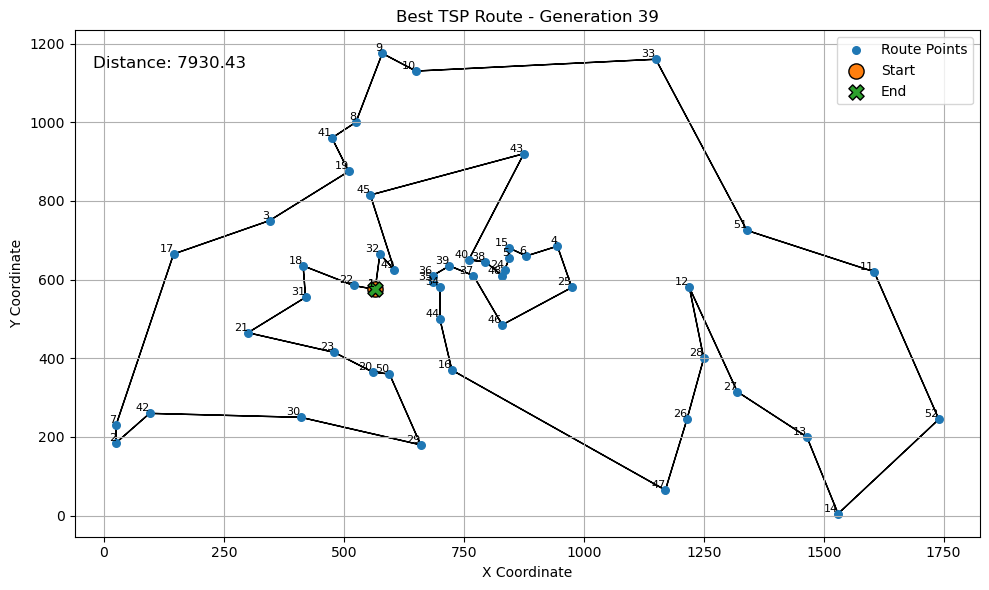

In [48]:
plot_figure(best_path, citys, gen, best_distance)

Generation 0, Best Distance: 26728.56
Generation 1, Best Distance: 16401.13
Generation 2, Best Distance: 9779.31
Generation 3, Best Distance: 9046.19
Generation 4, Best Distance: 8370.87
Generation 5, Best Distance: 8136.21
Generation 6, No improvement.
Generation 7, No improvement.
Generation 8, No improvement.
Generation 9, No improvement.
Generation 10, No improvement.
Generation 11, Best Distance: 8100.82
Generation 12, No improvement.
Generation 13, No improvement.
Generation 14, Best Distance: 8083.86
Generation 15, No improvement.
Generation 16, No improvement.
Generation 17, No improvement.
Generation 18, No improvement.
Generation 19, No improvement.
Generation 20, No improvement.
Generation 21, No improvement.
Generation 22, No improvement.
Generation 23, No improvement.
Generation 24, No improvement.
Generation 25, No improvement.
Generation 26, No improvement.
Generation 27, No improvement.
Generation 28, Best Distance: 8072.98
Generation 29, No improvement.
Generation 30, 

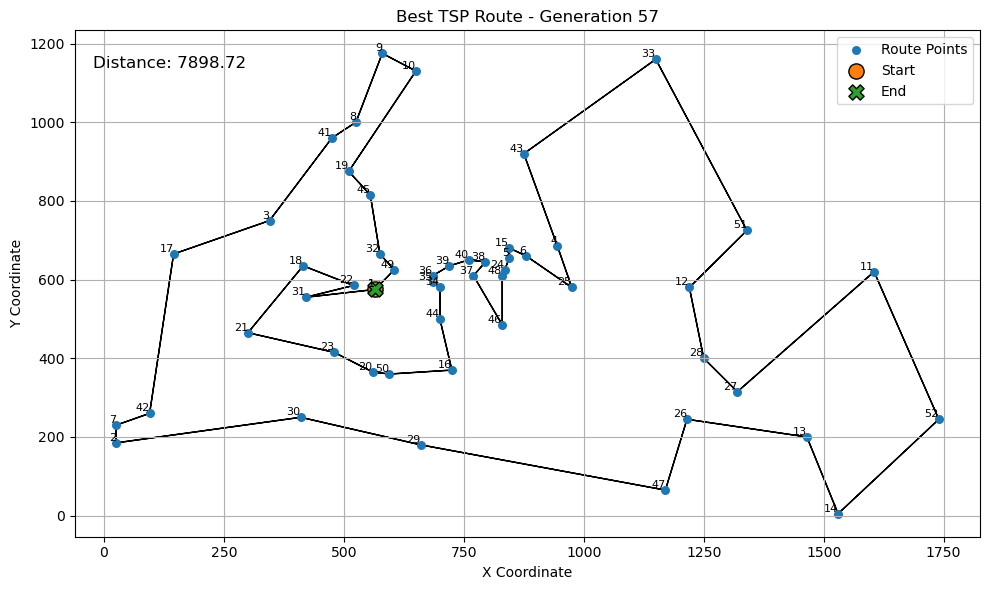

In [51]:
if __name__ == "__main__":
    start = time.time()
    goal = 8000
    number_of_individuals = 200
    iterations = 1000
    crossover_rate = 0.8
    original_mutation_rate = 0.03
    mutation_rate = original_mutation_rate
    org_mutations = 2
    num_mutations = org_mutations
    org_delta = 20
    set_delta = org_delta
    mutation_improved = False

    opt_style = 'random'  # 'best' or 'random'
    random_percents = 1
    random_improvements = (random_percents * number_of_individuals) // 100 # 1% of individuals will be improved with 2-opt

    elite_size_percentage = 1
    elite_size = (elite_size_percentage * number_of_individuals) // 100
    #elite_size = 2

    citys = pd.read_csv('berlin52.tsp', header=None, sep=r'\s+', skiprows=6, names=['x', 'y'])
    citys = citys[:-1]

    parents = generate_population(number_of_individuals, citys)    
    goal_reached = False
    best_ = 100000
    tries = 0
    fitness_over_time = {'iteration': [], 'best_distance': []}
    plot = 0
    gen = 0
    change = False
    optimization_time = []
    while not terminate_goal(best_, goal) and not gen >= iterations:
        improvement = False
        #gen += 1
        
        # Calculate fitness for the current population
        fitness_scores = 1 / calculate_fitness_population(parents, citys)
        #best_fitness = np.max(fitness_scores)
        #best_distance = 1 / best_fitness
        
        best_index = np.argmax(fitness_scores)

        # Upgrade the best individual using 2-opt
        if opt_style == 'best':
            z = time.time()       
            improved_individual, improved_fitness = two_opt(parents[best_index], citys)
            parents[best_index] = improved_individual
            fitness_scores[best_index] = improved_fitness
            y = time.time()
            optimization_time.append(y - z)
            #print(f"{opt_style} 2-opt took {y - z:.2f} seconds for 1 individual")

        # update the best fitness and distance
        best_fitness = np.max(fitness_scores)
        best_distance = 1 / best_fitness
        fitness_over_time['iteration'].append(gen)
        fitness_over_time['best_distance'].append(best_distance)

        #delta = gen - plot
        if best_distance < best_:
            best_path = parents[best_index]
            #path_coords = citys.iloc[best_path - 1][['x', 'y']].values
            #delta = gen - plot
            plot = gen
            best_generation = gen
            best_ = best_distance

            print(f"Generation {gen}, Best Distance: {best_distance:.2f}")
            #if mutation_improved:
            mutation_improved = False
            change = False
            tries = 0
            improvement = True

        elif not mutation_improved and mutation_rate > original_mutation_rate:
            mutation_rate = max(original_mutation_rate, mutation_rate - 0.005)

        if not improvement:
            print(f"Generation {gen}, No improvement.")

        if opt_style == 'random':
            indexes = []
            new_parents = parents.copy()
            improve_parents = []
            z = time.time()
            for i in range(random_improvements):
                random_index = random.randint(0, len(new_parents) - 1)
                if random_index not in indexes:
                    improve_parents.append(new_parents[random_index])
                    indexes.append(random_index)

            for i in range(len(improve_parents)):
                new_parent, new_fitness = two_opt(improve_parents[i], citys)
                parents[i] = new_parent
            y = time.time()
            optimization_time.append(y - z)
            #print(f"random 2-opt took {y - z:.2f} seconds for {len(improve_parents)} individuals")
        parents = update_population(parents, fitness_scores, citys, mutation_rate=mutation_rate, elite_size=elite_size)
        gen += 1

        if gen % 30 == 0:
            print(f"""Generation {gen}, 
                  Current Best Distance: {best_distance:.2f}, 
                  Mutation Rate: {mutation_rate:.2f}""")
    end = time.time()
    print(f"""
            Total optimization time: {end - start:.2f} seconds.
            TSP completed in {gen} generations.
            Best Distance for the salesman: {best_distance:.2f}.
            ------------------------------------------------------
            2-opt style: {opt_style}.
            2-opt improvements: {random_improvements} individuals.
            Average 2-opt time: {np.mean(optimization_time):.2f} seconds for {random_improvements} salesmen.
            """)
    plot_figure(best_path, citys, best_generation, best_distance)



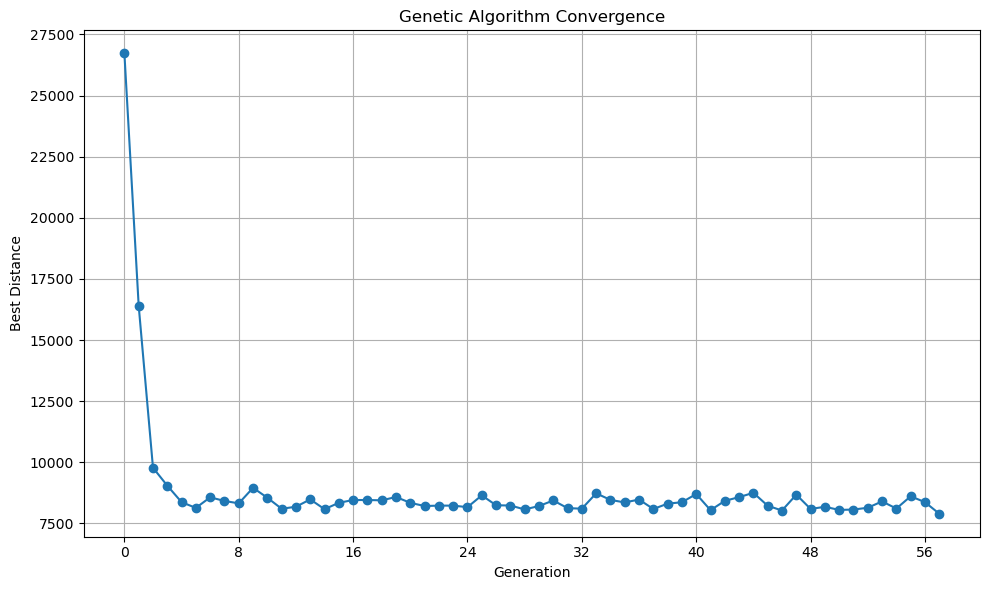

In [52]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Example plotting function for your fitness_over_time data
def plot_fitness_convergence(fitness_over_time):
    # Extract data
    iterations = fitness_over_time.get('iteration', [])
    distances  = fitness_over_time.get('best_distance', [])

    # Plot convergence with integer x-axis ticks
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(iterations, distances, marker='o', linestyle='-')
    ax.set_xlabel("Generation")
    ax.set_ylabel("Best Distance")
    ax.set_title("Genetic Algorithm Convergence")
    ax.grid(True)

    # Force integer ticks on x-axis
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    fig.tight_layout()
    plt.show()

# If you already have your fitness_over_time dict in the environment, just call:
# plot_fitness_convergence(fitness_over_time)


plot_fitness_convergence(fitness_over_time)


In [ ]:
print(best_path)

[ 1 35 36 39 40 15  6  5 24 48 38 37 34 44 50 20 23 31 18  3 17 21 42  7
  2 30 29 16 46 28 27 26 47 13 14 52 11 51 12 25  4 43 33 10  9  8 41 19
 45 32 49 22  1]
